## Import required libraries

In [1]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud


In [4]:
data = pd.read_csv("malicious_phish.csv")

In [5]:
print(data.shape)

(651191, 2)


So from the above output, we can observe that the dataset has 6,51,191 records with two columns url containing the raw URLs and type which istarget variable

In [6]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [7]:
data.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

### Plotting Word cloud

In [8]:
data_phish = data[data.type == "phishing"]
data_malware = data[data.type =="malware"]
data_deface = data[data.type == "defacement"]
data_benign = data[data.type =="benign"]

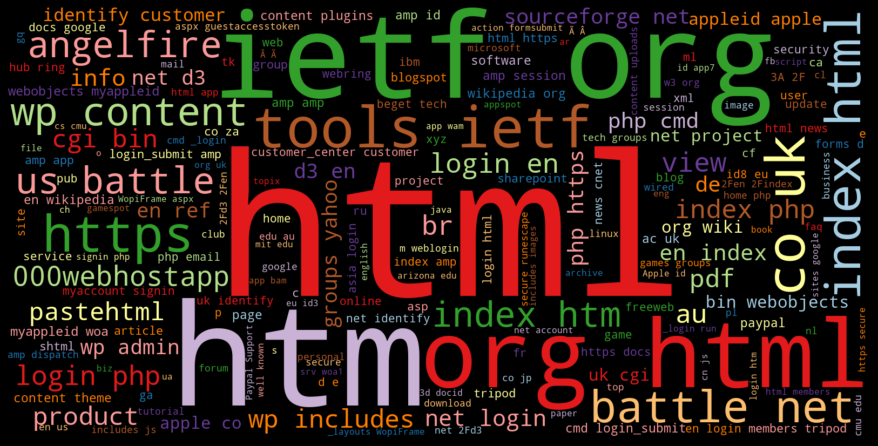

In [9]:
phish_url = " ".join(i for i in data_phish.url)
wordcloud = WordCloud(width = 1600,height = 800,colormap = "Paired").generate(phish_url)
plt.figure(figsize =(12,14),facecolor = "k")
plt.imshow(wordcloud,interpolation ="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

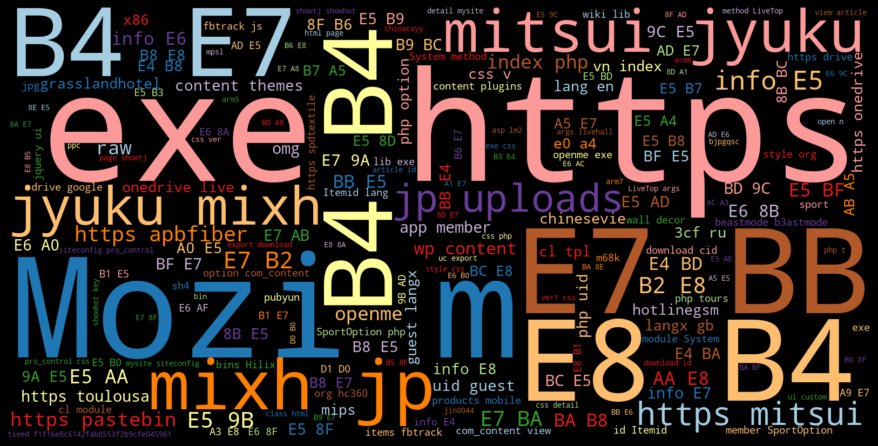

In [10]:
malware_url = " ".join(i for i in data_malware.url)
wordcloud = WordCloud(width = 1600,height = 800,colormap = "Paired").generate(malware_url)
plt.figure(figsize =(12,14),facecolor = "k")
plt.imshow(wordcloud,interpolation ="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

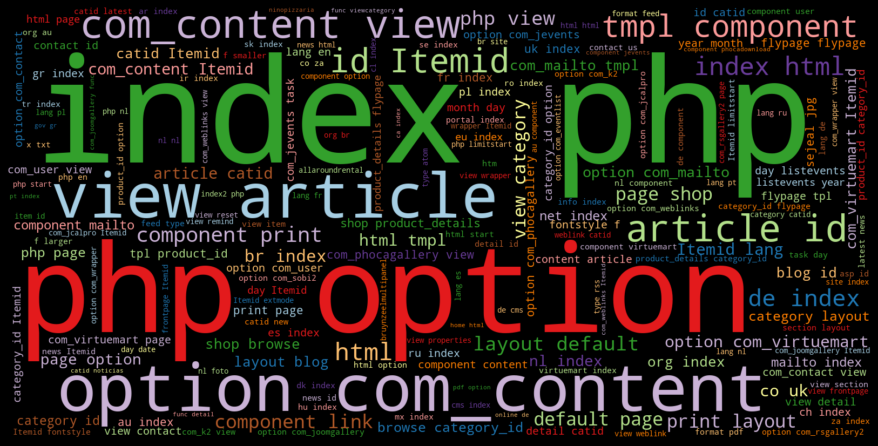

In [11]:
deface_url = " ".join(i for i in data_deface.url)
wordcloud = WordCloud(width = 1600,height = 800,colormap = "Paired").generate(deface_url)
plt.figure(figsize =(12,14),facecolor = "k")
plt.imshow(wordcloud,interpolation ="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

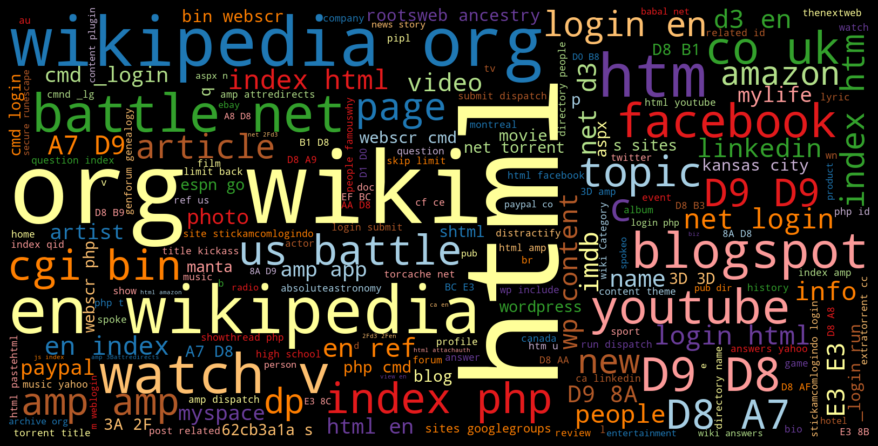

In [12]:
benign_url = " ".join(i for i in data_benign.url)
wordcloud = WordCloud(width = 1600,height = 800,colormap = "Paired").generate(benign_url)
plt.figure(figsize =(12,14),facecolor = "k")
plt.imshow(wordcloud,interpolation ="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Feature engineering

In this step we need to extract the following lexical features from raw URLs.


#### Having_ip_adress:
Generally cyber attackers use an IP address in place of the domain name to hide the identity of the website. this feature will check whether the URL has IP address or not.
#### abnormal_url:
his feature can be extracted from the WHOIS database. For a legitimate website, identity is typically part of its URL.
#### Google_index:
In this feature, we check whether the URL is indexed in google search console or not.
#### Count:
The phishing or malware websites generally use more than two sub-domains in the URL. Each domain is separated by dot (.). If any URL contains more than three dots(.), then it increases the probability of a malicious site.
#### Count-www:
Generally most of the safe websites have one www in its URL. This feature helps in detecting malicious websites if the URL has no or more than one www in its URL.
#### count@:
he presence of the “@” symbol in the URL ignores everything previous to it.
#### count_dir:
The presence of multiple directories in the URL generally indicates suspicious websites.
#### Count_embeded_domain:
The number of the embedded domains can be helpful in detecting malicious URLs. It can be done by checking the occurrence of “//” in the URL.
#### Suspicious words in URL:
Malicious URLs generally contain suspicious words in the URL such as PayPal, login, sign in, bank, account, update, bonus, service, ebayisapi, token, etc. We have found the presence of such frequently occurring suspicious words in the URL as a binary variable i.e., whether such words present in the URL or not.
#### Short_url: 
This feature is created to identify whether the URL uses URL shortening services like bit. \ly, goo.gl, go2l.ink, etc.
#### Count_https:
Generally malicious URLs do not use HTTPS protocols as it generally requires user credentials and ensures that the website is safe for transactions. So, the presence or absence of HTTPS protocol in the URL is an important feature.
#### Count_http:
Most of the time, phishing or malicious websites have more than one HTTP in their URL whereas safe sites have only one HTTP.
#### Count%:
As we know URLs cannot contain spaces. URL encoding normally replaces spaces with symbol (%). Safe sites generally contain less number of spaces whereas malicious websites generally contain more spaces in their URL hence more number of %.
#### Count?:
The presence of symbol (?) in URL denotes a query string that contains the data to be passed to the server. More number of ? in URL definitely indicates suspicious URL.
#### Count- : 
Phishers or cybercriminals generally add dashes(-) in prefix or suffix of the brand name so that it looks genuine URL. For example. "www.flipkart-india.com."
#### url_length:
Attackers generally use long URLs to hide the domain name. We found the average length of a safe URL is 74
#### Hostname_length:
The length of the hostname is also an important feature for detecting malicious URLs.
#### First directory length: 
This feature helps in determining the length of the first directory in the URL. So looking for the first ‘/’ and counting the length of the URL up to this point helps in finding the first directory length of the URL. For accessing directory level information we need to install python library TLD. You can check this link for installing TLD.
#### Length of top-level domains: 
A top-level domain (TLD) is one of the domains at the highest level in the hierarchical Domain Name System of the Internet. For example, in the domain name www.example.com, the top-level domain is com. So, the length of TLD is also important in identifying malicious URLs. As most of the URLs have .com extension. TLDs in the range from 2 to 3 generally indicate safe URLs.
#### Count_digits: 
The presence of digits in URL generally indicate suspicious URLs. Safe URLs generally do not have digits so counting the number of digits in URL is an important feature for detecting malicious URLs.
#### Count_letters: 
The number of letters in the URL also plays a significant role in identifying malicious URLs. As attackers try to increase the length of the URL to hide the domain name and this is generally done by increasing the number of letters and digits in the URL.



In [13]:
import re
#Use of IP or not in domain
def Having_ip_address(url):
    match = re.search(
     '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
    '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
         '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
data["use_of_ip"] = data['url'].apply(lambda i: Having_ip_address(i))

In [14]:
from urllib.parse import urlparse

In [15]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0
    
data["abnormal_url"] = data["url"].apply(lambda i: abnormal_url(i))

In [16]:
!pip install googlesearch-python
#to find whether it is google indexed or not

In [17]:
from googlesearch import search

In [18]:
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
data['google_index'] = data['url'].apply(lambda i:google_index(i))

In [19]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

data['count.'] = data['url'].apply(lambda i: count_dot(i))

In [20]:
data.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [21]:
def count_www(url):
    url.count('www')
    return url.count('www')
data['count-www'] = data['url'].apply(lambda i:count_www(i))

In [22]:
def count_atrate(url):
    return url.count('@')

data['count@'] = data['url'].apply(lambda i:count_atrate(i))

In [23]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
data['count_dir'] = data['url'].apply(lambda i: no_of_dir(i))

In [24]:
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')
data["count_embed_domain"] = data['url'].apply(lambda i: no_of_embed(i))

In [25]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

data['short_url'] = data['url'].apply(lambda i: shortening_service(i))

In [26]:
def count_https(url):
    return url.count('https')
data['count-https'] = data['url'].apply(lambda i:count_https(i))

In [27]:
def count_http(url):
    return url.count('http')
data['count-http'] = data['url'].apply(lambda i:count_http(i))

In [28]:
def count_per(url):
    return url.count('%')
data['count%'] = data['url'].apply(lambda i:count_per(i))

In [29]:
def count_ques(url):
    return url.count('?')
data['count?'] = data['url'].apply(lambda i:count_ques(i))

In [30]:
def count_hyphen(url):
    return url.count('-')

data['count-'] = data['url'].apply(lambda i:count_hyphen(i))

In [31]:
def count_equal(url):
    return url.count('=')
data['count='] = data['url'].apply(lambda i:count_equal(i))

In [32]:
def url_length(url):
    return len(str(url))

data['url_length'] = data['url'].apply(lambda i:url_length(i))

In [33]:
def hostname_length(url):
    return len(urlparse(url).netloc)
data['hostname_length'] = data['url'].apply(lambda i:hostname_length(i))

In [34]:
data.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domain,short_url,count-https,count-http,count%,count?,count-,count=,url_length,hostname_length
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,16,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,0,0,0,0,0,0,0,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,0,0,0,0,0,0,0,31,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,0,0,1,0,1,1,4,88,21
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,0,0,1,0,1,1,3,235,23


In [35]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
    
data['sus_url'] = data['url'].apply(lambda i:suspicious_words(i))

In [36]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits+1
    return digits

data['count-digits'] = data['url'].apply(lambda i:digit_count(i))

In [37]:
def letter_count(url):
    letters =0
    for i in url:
        if i.isalpha:
            letters = letters+1
    return letters
data['count-letters'] = data['url'].apply(lambda i:letter_count(i))

In [38]:
pip install tld

Note: you may need to restart the kernel to use updated packages.


In [39]:
from urllib.parse import urlparse
from tld import get_tld #top level directry which checks like .com and all
import os.path

In [40]:
#first directory length
def fd_length(url):
    urlpath = urlparse(url).path
    try:
        return lrn(urlpath.split('/')[1])
    except:
        return 0
data['fd_length'] = data['url'].apply(lambda i:fd_length(i))
#length of top level domain
data['tld'] = data['url'].apply(lambda i:get_tld(i,fail_silently=True))

In [41]:
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1
data['tld_length'] = data['tld'].apply(lambda i:tld_length(i))

In [42]:
data.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domain,...,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters,fd_length,tld,tld_length
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,1,0,16,0,0,0,16,0,None,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,35,0,0,1,35,0,None,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,31,0,0,1,31,0,None,-1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,4,88,21,0,7,88,0,be,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,3,235,23,0,22,235,0,net,3


Now we drop the irrelevant columns i.e URL,google_index and tld

In [43]:
data = data.drop("tld",1)

In [44]:
data.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domain', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [45]:
data["type"].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

### Exploratory data analysis

### 1. Distribution of use_of_ip 

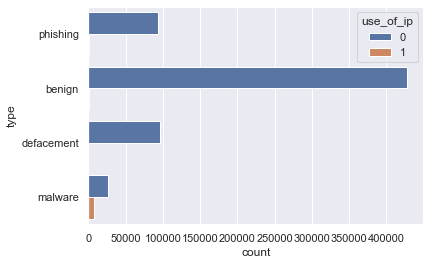

In [46]:
import seaborn as sns
sns.set(style = "darkgrid")
ax = sns.countplot(y="type",data = data,hue = "use_of_ip")

### 2. Distribution of abnormal url

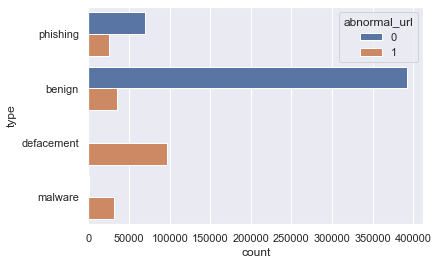

In [47]:
sns.set(style = "darkgrid")
ax = sns.countplot(y="type",data = data,hue = "abnormal_url")

### 03.Distribution of google index

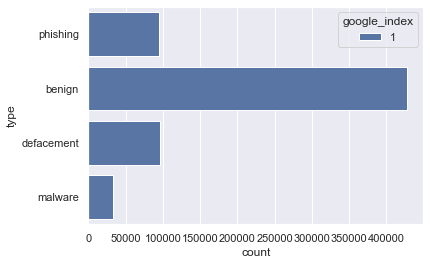

In [48]:
sns.set(style = "darkgrid")
ax = sns.countplot(y="type",data = data,hue = "google_index")

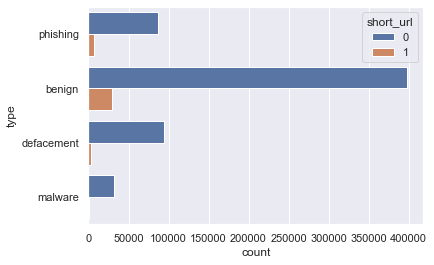

In [49]:
sns.set(style = "darkgrid")
ax = sns.countplot(y="type",data = data,hue = "short_url")

### 5.Distribution of suspicious URL

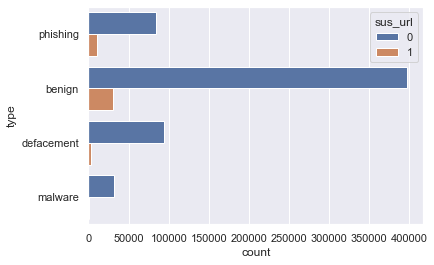

In [50]:
sns.set(style = "darkgrid")
ax = sns.countplot(y="type",data = data,hue = "sus_url")

### 6. Distribution of count of [.] dot

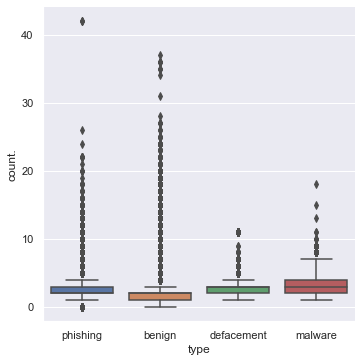

In [51]:
sns.set(style = "darkgrid")
ax = sns.catplot(x="type",y="count.",kind = "box",data=data)

### 7. Distribution of count-www

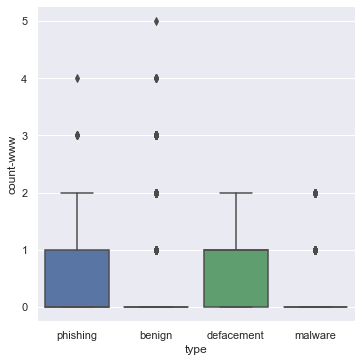

In [52]:
sns.set(style = "darkgrid")
ax = sns.catplot(x="type",y="count-www",kind = "box",data=data)

### 8. Distribution of count@

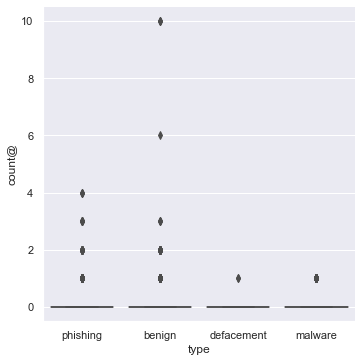

In [53]:
sns.set(style = "darkgrid")
ax = sns.catplot(x="type",y="count@",kind = "box",data=data)

### 9. Distribution of count_dir

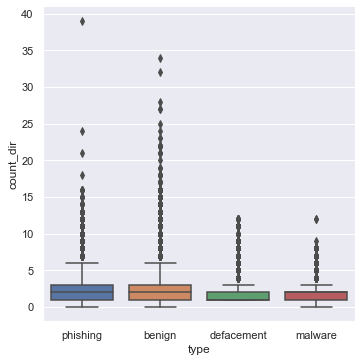

In [54]:
sns.set(style = "darkgrid")
ax = sns.catplot(x="type",y="count_dir",kind = "box",data=data)

### 10. Distribution of hostname length

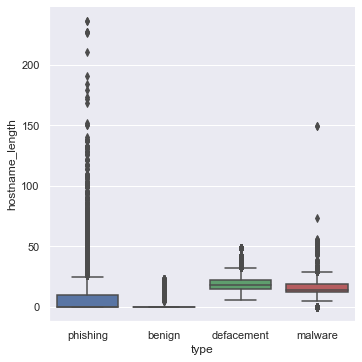

In [55]:
sns.set(style = "darkgrid")
ax = sns.catplot(x="type",y="hostname_length",kind = "box",data=data)

### 11.Distribution of top level domain length

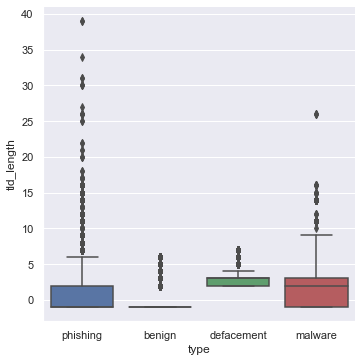

In [56]:
sns.set(style = "darkgrid")
ax = sns.catplot(x="type",y="tld_length",kind = "box",data=data)

### Label encoder

In [57]:
from sklearn.preprocessing import LabelEncoder

In [58]:
lb_make = LabelEncoder()
data['type_code'] = lb_make.fit_transform(data["type"])
data["type_code"].value_counts()

0    428103
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

### Segregating Feature and target variables

In [59]:
X = data[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domain', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

In [60]:
y = data["type_code"]

In [61]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domain,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,16
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,0,-1,1,35
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,0,-1,1,31
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,0,2,7,88
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,0,3,22,235


In [62]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domain', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters'],
      dtype='object')

### Train Test Split

In [63]:
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify = y,test_size=0.2,shuffle = True,random_state=5)

### Model building

### 1.Random forest classifier

In [64]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100,max_features = "sqrt")


In [65]:
rf.fit(x_train,y_train)

RandomForestClassifier(max_features='sqrt')

In [66]:
y_pred_rf = rf.predict(x_test)

In [67]:
print(classification_report(y_test,y_pred_rf,target_names = ['benign','defacement','phishing','malware']))

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.97      0.99      0.98     19292
    phishing       0.98      0.94      0.96      6504
     malware       0.90      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.94      0.95    130239
weighted avg       0.96      0.96      0.96    130239



In [68]:
score = accuracy_score(y_test,y_pred_rf)
print(f"accuracy: {score*100}")

accuracy: 96.1202097681954


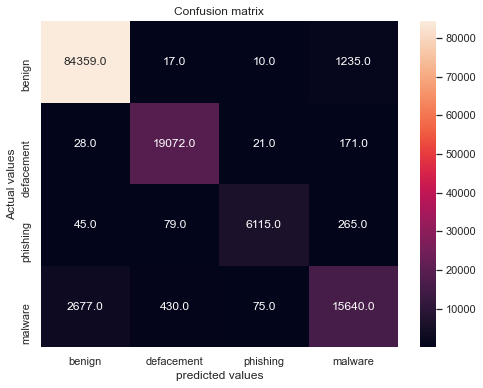

In [69]:
cm = confusion_matrix(y_test,y_pred_rf)
cm_data = pd.DataFrame(cm,
                      index = ['benign','defacement','phishing','malware'],
                      columns = ['benign','defacement','phishing','malware'])
plt.figure(figsize = (8,6))
sns.heatmap(cm_data,annot = True, fmt = ".1f")
plt.title("Confusion matrix")
plt.ylabel("Actual values")
plt.xlabel("predicted values")
plt.show()

<AxesSubplot:>

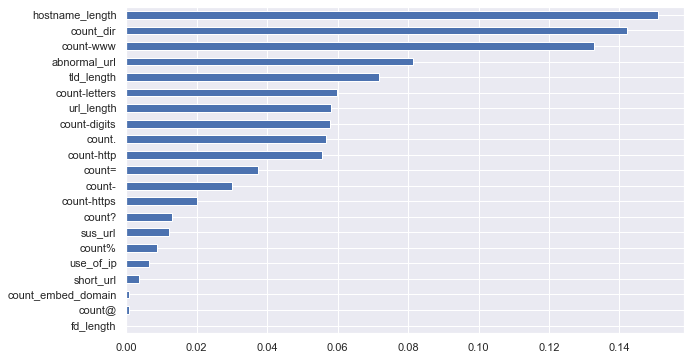

In [70]:
feat_importances = pd.Series(rf.feature_importances_,index = x_train.columns)
feat_importances.sort_values().plot(kind = "barh",figsize=(10,6))

### Prediction

In [71]:
def main(url):
    status = []
    status.append(Having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))
    
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    
    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    
    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)
      
    status.append(tld_length(tld))
    
    return status
    

In [78]:
# predict function 
def get_prediction_from_url(test_url):
    features_test = main(test_url)
    print(features_test)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))
    print(features_test)
    pred = rf.predict(features_test)
    print(pred)
    if int(pred[0]) == 0:
        
        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:
        
        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res
        
    elif int(pred[0]) == 3.0:
        
        res="MALWARE"
        return res


In [82]:
urls = 'titaniumcorporate.co.z'
#for url in urls:
print(get_prediction_from_url(urls))

[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 22, 0, -1]
[[ 0  0  2  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0 22  0 -1]]
[3]
MALWARE


In [74]:
import pickle
with open('Phishing_Url_detection.pickle','wb') as f:
    pickle.dump(rf,f)

In [75]:
import json
columns = {
    'data_columns':[col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))